In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
tfk = tf.keras
tfkl = tf.keras.layers  

In [2]:
dataset_dir = '/kaggle/input/foglie-split/foglie_split'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
print(train_dir)

/kaggle/input/foglie-split/foglie_split/train


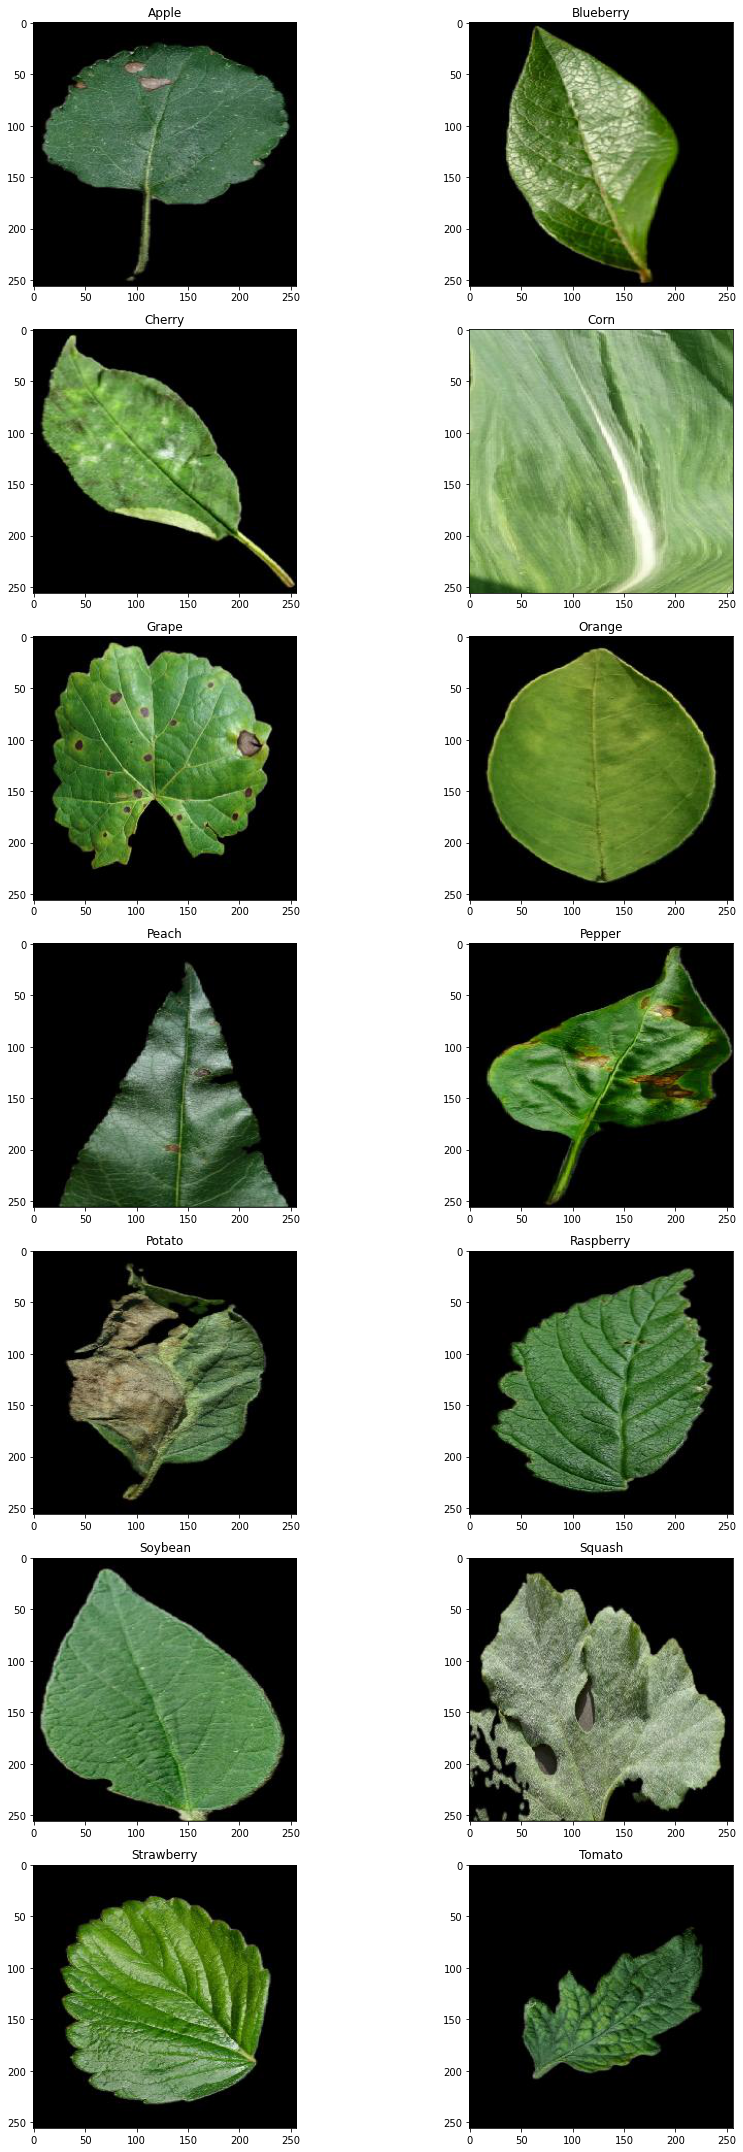

In [3]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
    if i < len(labels):
        class_imgs = next(os.walk('{}/{}'.format(train_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(train_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [6]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)

In [7]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
data_aug_gen = ImageDataGenerator(rotation_range=90,
                                        #height_shift_range=50,
                                        #width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='reflect',
                                        #samplewise_center=True,
                                        #samplewise_std_normalization=True,
                                 )
normal_gen = ImageDataGenerator() 
# rescale value is multiplied to the image
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = data_aug_gen.flow_from_directory(directory=train_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=16,
                                                       shuffle=True,
                                                       seed=seed)
aug_val_gen = normal_gen.flow_from_directory(directory=validation_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=16,
                                                       shuffle=True,
                                                       seed=seed)




Found 15949 images belonging to 14 classes.
Found 1779 images belonging to 14 classes.


In [8]:
# Apply same preprocessing used to train the supernet 
from tensorflow.keras.applications.efficientnet import preprocess_input
x_train = preprocess_input(aug_train_gen)
x_val = preprocess_input(aug_val_gen)

In [9]:
supernet = tfk.applications.efficientnet.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
    pooling='avg'
)
#supernet.summary()
#tfk.utils.plot_model(supernet)

2021-11-21 16:44:21.679610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 16:44:21.808465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 16:44:21.809197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 16:44:21.810294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258088960/258076736 [==============================] - 1s 0us/step


In [10]:
# Use the supernet as feature extractor
supernet.trainable = False

#inputs = tfk.Input(shape=(256,256,3))
#x = tfkl.Resizing(224, 224, interpolation="bicubic")(inputs)
#x = supernet(x)
#x = tfkl.Flatten(name='Flattening')(supernet.output)
#x = tfkl.Dropout(0.25, seed=seed)(supernet.output)
x = tfkl.Dense(
    1024, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer = tfk.regularizers.l2(0.002))(supernet.output)
#x = tfkl.Dropout(0.25, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer = tfk.regularizers.l2(0.002))(x)
#x = tfkl.Dropout(0.25, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer = tfk.regularizers.l2(0.002))(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    kernel_regularizer = tfk.regularizers.l2(0.002))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=supernet.input, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
#tl_model.summary()

In [11]:
#for i, layer in enumerate(tl_model.layers[-66:]):
#  layer.trainable=True
#for i, layer in enumerate(tl_model.layers):
#   print(i, layer.name, layer.trainable)

In [12]:
trainImages = 15949
class_w = {}
for i, l in enumerate(labels):
  path, dirs, files = next(os.walk("{}/{}".format(train_dir, l)))
  labelCount = len(files)
  class_w[i] = (1 - labelCount/trainImages)

print(class_w)

{0: 0.9442598282023952, 1: 0.9736660605680607, 2: 0.9671452755658662, 3: 0.9319706564674901, 4: 0.9177377892030848, 5: 0.9013731268418083, 6: 0.9448868267602984, 7: 0.9568624992162518, 8: 0.9596212928710264, 9: 0.9851401341776914, 10: 0.9088344096808577, 11: 0.9676468744121889, 12: 0.9620665872468493, 13: 0.6787886387861308}


In [13]:
# Train the model
tl_history = tl_model.fit(
    x = x_train,
    batch_size = 256,
    epochs = 200,
    validation_data = x_val,
    class_weight = class_w,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True),]
                 #tfk.callbacks.ModelCheckpoint(filepath="/kaggle/working/checkpoints", save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)]
).history

2021-11-21 16:44:32.152645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-21 16:44:49.880374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


997/997 [==============================] - 408s 387ms/step - loss: 1.2894 - accuracy: 0.8282 - val_loss: 0.7702 - val_accuracy: 0.8960
Epoch 2/200
997/997 [==============================] - 311s 312ms/step - loss: 0.6697 - accuracy: 0.8853 - val_loss: 0.5465 - val_accuracy: 0.9365
Epoch 3/200
997/997 [==============================] - 311s 312ms/step - loss: 0.5607 - accuracy: 0.9075 - val_loss: 0.5219 - val_accuracy: 0.9258
Epoch 4/200
997/997 [==============================] - 308s 308ms/step - loss: 0.5300 - accuracy: 0.9077 - val_loss: 0.4720 - val_accuracy: 0.9399
Epoch 5/200
997/997 [==============================] - 314s 314ms/step - loss: 0.4938 - accuracy: 0.9206 - val_loss: 0.4893 - val_accuracy: 0.9264
Epoch 6/200
997/997 [==============================] - 314s 315ms/step - loss: 0.4690 - accuracy: 0.9223 - val_loss: 0.4511 - val_accuracy: 0.9421
Epoch 7/200
997/997 [==============================] - 328s 329ms/step - loss: 0.4565 - accuracy: 0.9277 - val_loss: 0.4878 - val_

In [14]:
tl_model.save("/kaggle/working/efficientnetb7finetuningAugMoreDense")

2021-11-21 17:31:49.210725: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
